In [148]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from bs4 import BeautifulSoup
from seaborn import barplot

# Load, explore data, and prepare for model

In [149]:
train = pd.read_csv('data/drugsComTrain_raw.csv')

In [150]:
test = pd.read_csv('data/drugsComTest_raw.csv')

## Data exploration

In [151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [152]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53766 non-null  int64 
 1   drugName     53766 non-null  object
 2   condition    53471 non-null  object
 3   review       53766 non-null  object
 4   rating       53766 non-null  int64 
 5   date         53766 non-null  object
 6   usefulCount  53766 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.9+ MB


### Drop missing values and check counts again

In [153]:
train.dropna(axis=0,inplace=True)
test.dropna(axis=0,inplace=True)

In [154]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     160398 non-null  int64 
 1   drugName     160398 non-null  object
 2   condition    160398 non-null  object
 3   review       160398 non-null  object
 4   rating       160398 non-null  int64 
 5   date         160398 non-null  object
 6   usefulCount  160398 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 9.8+ MB


In [155]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53471 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53471 non-null  int64 
 1   drugName     53471 non-null  object
 2   condition    53471 non-null  object
 3   review       53471 non-null  object
 4   rating       53471 non-null  int64 
 5   date         53471 non-null  object
 6   usefulCount  53471 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.3+ MB


## General statistics and distribution of dataset

In [156]:
train['rating'].describe()

count    160398.000000
mean          6.995923
std           3.272303
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

In [157]:
test['rating'].describe()

count    53471.000000
mean         6.976829
std          3.286228
min          1.000000
25%          4.000000
50%          8.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

## Get idea of balance in rating values in dataset

In [158]:
print("RATING VALUE COUNTS, 1-10, TRAIN SET")

for i in range(1,11):
    count = train['rating'].value_counts()[i]
    print(f"{i}: {count} ({round(100*count/train.shape[0],3)}%)")

RATING VALUE COUNTS, 1-10, TRAIN SET
1: 21504 (13.407%)
2: 6879 (4.289%)
3: 6465 (4.031%)
4: 4980 (3.105%)
5: 7959 (4.962%)
6: 6301 (3.928%)
7: 9395 (5.857%)
8: 18791 (11.715%)
9: 27379 (17.069%)
10: 50745 (31.637%)


In [159]:
print("RATING VALUE COUNTS, 1-10, TEST SET")

for i in range(1,11):
    count = test['rating'].value_counts()[i]
    print(f"{i}: {count} ({round(100*count/test.shape[0],3)}%)")

RATING VALUE COUNTS, 1-10, TEST SET
1: 7265 (13.587%)
2: 2324 (4.346%)
3: 2197 (4.109%)
4: 1642 (3.071%)
5: 2691 (5.033%)
6: 2102 (3.931%)
7: 3075 (5.751%)
8: 6118 (11.442%)
9: 9120 (17.056%)
10: 16937 (31.675%)


In [160]:
import matplotlib.pyplot as plt

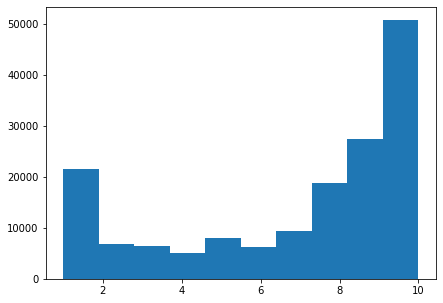

In [161]:
plt.figure(figsize=(7,5))
fig = plt.hist(np.array(train['rating']),bins=10)

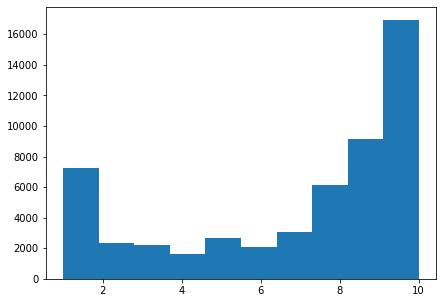

In [162]:
plt.figure(figsize=(7,5))
fig = plt.hist(np.array(test['rating']),bins=10)

## Create binned classes (Negative,Positive)

In [163]:
#neg = 1-5 : class 0
#pos = 6-10 : class 1
def rate_class(rating):
    neg = np.arange(1,6)
    pos = np.arange(6,11)
    
    if(rating in neg):
        return 0
    elif(rating in pos):
        return 1
    else:
        return 'Error'

In [164]:
train['rating_class']=train['rating'].apply(rate_class)
test['rating_class']=test['rating'].apply(rate_class)

In [165]:
train = train[train['rating_class']!='Error']
test = test[test['rating_class']!='Error']

## Check distribution of class counts

In [166]:
count_neg_train = train['rating_class'].value_counts()[0]
count_pos_train = train['rating_class'].value_counts()[1]
v1="Negative class (0)"
v2="Positive class (1)"

print(f"{v1}: {count_neg_train} ({round(100*count_neg_train/train.shape[0],3)}%)")
print(f"{v2}: {count_pos_train} ({round(100*count_pos_train/train.shape[0],3)}%)")

Negative class (0): 47787 (29.793%)
Positive class (1): 112611 (70.207%)


In [167]:
count_neg_test = test['rating_class'].value_counts()[0]
count_pos_test = test['rating_class'].value_counts()[1]
v1="Negative class (0)"
v2="Positive class (1)"

print(f"{v1}: {count_neg_test} ({round(100*count_neg_test/test.shape[0],3)}%)")
print(f"{v2}: {count_pos_test} ({round(100*count_pos_test/test.shape[0],3)}%)")

Negative class (0): 16119 (30.145%)
Positive class (1): 37352 (69.855%)


In [168]:
## The dataset is imbalanced when it comes to positive and negative reviews.
## There are many more positive than negative reviews.
## Positive reviews make up about 70% of the dataset, while
## Negative reviews make up the other 30% of both train and test sets.

## Remove numbers from reviews

In [169]:
def remove_num(review):
    review_text = BeautifulSoup(review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    return letters_only

In [170]:
train['review'] = train['review'].apply(remove_num)
test['review'] = test['review'].apply(remove_num)

## Save the files with numbers removed and classes defined

* Before we transform with TfidfVectorizer, we want to save these cleaned but untransformed dataframes so we can run a gridsearch on the best TfidfVectorizer parameters.

In [171]:
#train[['review','rating_class']].to_csv('data/train_letters_removed.csv')

In [172]:
#test[['review','rating_class']].to_csv('data/test_letters_removed.csv')

## Visualize words

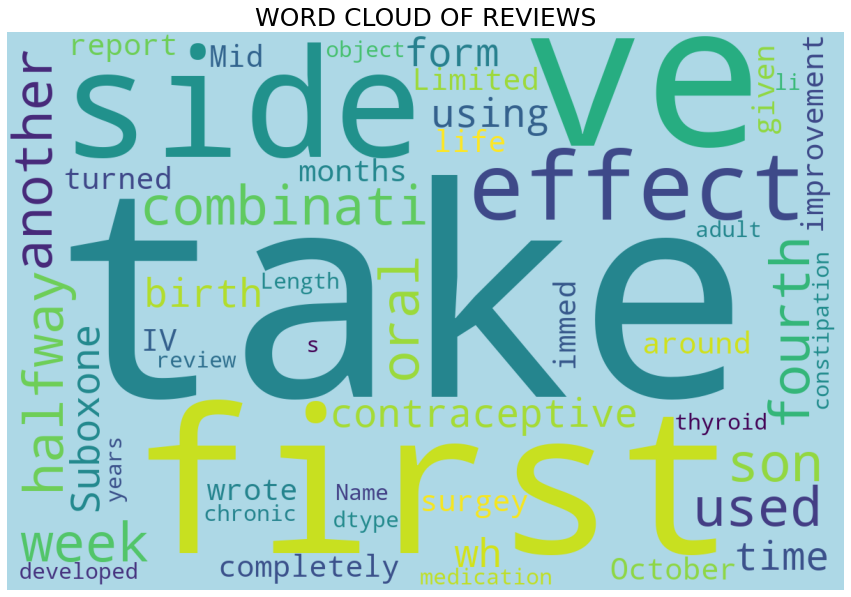

In [173]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

stop_words = set(STOPWORDS)


wordcloud = WordCloud(background_color = 'lightblue', stopwords = stop_words, width = 1200, height = 800).generate(str(train['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## Use TfidVectorizer to extract features from reviews

In [174]:
# * ngram_range:
# (1,2) = unigrams and bigrams, removed=unigrams only, ngram_range=(2,2) is bigrams
# only. Higher n-grams can be helpful but can lead to overfitting and increases features a lot.
# * min_df = number of documents the word must appear in before it becomes a feature
# * stop words = some stop words are emotional words (e.g aren't). May want to include these
# * max_features = maximum number of features to extract based on word frequency

from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,min_df=5,ngram_range=(1,2),max_df=0.5,max_features=5000).fit(train['review'].values)

print("Number of features: ", len(vect.get_feature_names()))

Number of features:  5000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Transform using tfid vector and create X_train,X_test,y_train,y_test

In [175]:
words_train = vect.transform(train['review'].values)
words_test = vect.transform(test['review'].values)

In [176]:
feature_names = vect.get_feature_names()

In [177]:
X_train = pd.DataFrame(words_train.toarray(), columns = feature_names)
X_test = pd.DataFrame(words_test.toarray(), columns = feature_names)

In [178]:
y_train = train['rating_class']
y_test = test['rating_class']

## Visualize TfidfVectorize results

### Plot the top 1,000 features for record counts (frequency) and highest correlations

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


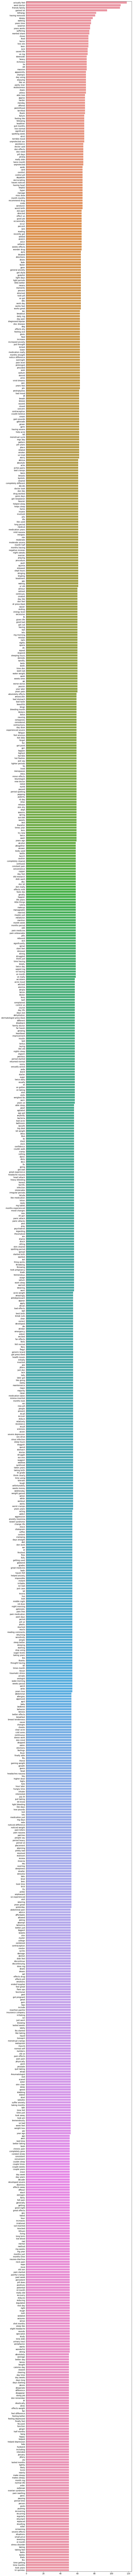

In [179]:
record_counts  = {}
for i in range(X_train.shape[1]):
    record_counts[feature_names[i]] = sum(X_train.iloc[i,:] > 0)

#Sort list descending
record_counts = dict(sorted(record_counts.items(), key=lambda item: item[1],reverse=True))

plot = barplot(list(record_counts.values())[:1000],list(record_counts.keys())[:1000])
plot.figure.set_size_inches(10,250)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


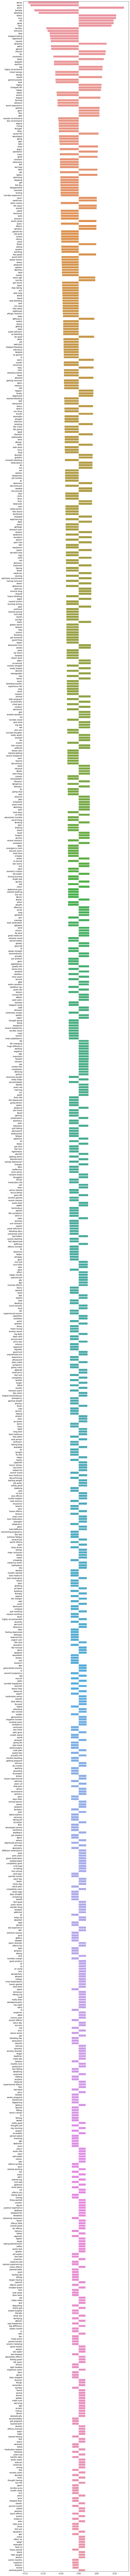

In [180]:
record_corr  = {}
for i in range(X_train.shape[1]):
    record_corr[feature_names[i]] = np.corrcoef(X_train.iloc[:,i],y_train)[1][0]

#Sort list descending
record_corr = dict(sorted(record_corr.items(), key=lambda item: abs(item[1]),reverse=True))

plot = barplot(list(record_corr.values())[:1000],list(record_corr.keys())[:1000])
plot.figure.set_size_inches(10,250)

## Save cleaned dfs

In [181]:
X_train

,abdomen,abdominal,abdominal pain,abilify,ability,able,able eat,able focus,able function,able lose,...,zero effects,zero sex,zits,zofran,zoloft,zoloft mg,zombie,zyban,zyprexa,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
#Have to reset y_train and y_test index because y_train was filtered on when train was filtered on
#and rows were dropped.
X_train['rating_class']=y_train.reset_index().drop('index',axis=1)
X_test['rating_class']=y_test.reset_index().drop('index',axis=1)

In [183]:
X_train.to_csv('data/train_clean.csv')

In [184]:
X_test.to_csv('data/test_clean.csv')